[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/bayes_course_june_2024/blob/master/notebooks/Section1_2-Choosing_Priors.ipynb)

# Choosing Prior Distributions and Likeihood Functions

It may already be apparent to you that specifying a Bayesian model (or any statistical model, as it happens) requires making a number of **subjective choices**. In particular, we need to specify the prior distributions for our parameters. A prior is a distribution that represents our beliefs about the parameters before we have seen the data.

This notebook will guide through that process. We'll learn:
- Some common priors for common use-cases
- How to choose priors visually
- How to choose priors computationally

There has been much debate in the statistical community over the years about Bayesian priors. In the end though, most of the fuss is unwarranted: priors are just **hypotheses** (or more correctly, components of a hypothesis -- your model), and hypotheses can be tested and refined.

This already answers the main question we hear from beginners: "*what's the best prior?*". Remember that there are bad priors, but there is no best, ideal prior. You're never tied to a single prior, you can always change it if warranted.

## Principles vs. Techniques

This is part of the "art" of Bayesian statistical modeling: you get to be creative, because with explicit control over the components of your model you can explore different hypotheses. This requires learning **principles** instead of **techniques**. Once you understand those core principles, you can always combine them to creatively answer your questions. Whereas, if you focus on techniques, you're lost the day you don't have the technique that exactly fits your problem.

However, learning those principles can be intimidating and overwhelming at first.

## Choosing a Likelihood Function

In the debate over prior choice, the likelihood function is often overlooked. The likelihood function is the workhorse of the model, as it determines how the information from the data are incorporated into the model for inference. 

$$\Large Pr(y | \theta)$$

The likelihood function returns the probability of data values given the parameters. It can also be used as a sampling distribution for the data in a simulation context. 

Ultimately, the likelihood function describes how observed data are distributed, conditional on the modeled parameters. Thus, the criteria for choosing a likelihood are related to what the data look like:

- **data type**: Is the target variable a continuous variable, such as height, distance, time, or a z-score? Or is it a discrete variable, such as a count, a binary variable, or a categorical variable?
- **variable support**: Can the variable take any real value, or is it restricted to a certain range, such as positive values, or values between 0 and 1?
- **shape**: Are the data approximately symmetric? Do they have extreme values? Are they multimodal? Are they truncated or censored?

A decision tree for selecting a likelihood can be helpful. This is by no means exhaustive and you should not feel yourself constrained to these choices.

![image](images/likelihood.png)

## Choosing Prior Distributions

While choosing prior distributions may superficially seem similar to choosing likelihood functions, it is a fundamentally different task. The goal with prior specification is to encode whatever information is available regarding the unknown parameter in question, outside of what is provided by the data. While the likelihood function is meant to describe **aleatoric uncertainty**, the prior distribution is meant to describe **epistemic uncertainty**.

Aleatoric uncertainty is **inherent stochasticity** in the system itself. It's the kind of uncertainty you can't reduce no matter how much information (*i.e.* data) you have. Think about the probability of observing a particular card drawn from a deck of cards -- despite complete knowledge of the underlying system, the card drawn from a shuffled deck will always be random. 

Epistemic uncertainty, on the other hand, is due to a lack of **knowledge**, and that uncertainty can be reduced by gathering more information. For instance, you might be unsure about the weather tomorrow. But by checking the forecast, you can reduce your epistemic uncertainty.

When the sample size of your training dataset is large, the posterior distribution will converge to a normal distribution regardless of the prior distribution, as long as the prior is a proper distribution (integrates to 1). This is known as the Bernstein-von Mises theorem (or, **Bayesian central limit theorem**). As a result, for large sample sizes, the choice of prior distribution becomes less critical since the data will dominate and the posterior will approximate a normal distribution.

Theoretical considerations aside, the mechanics of choosing a prior distribution is not unlike those for choosing a likelihood function. The same considerations apply:

- **data type**: In practice, latent variables tend to be continuous (at least more so than data), so continuous priors are more common. However, discrete priors can be useful in some cases. This will have implications on the method for fitting the model, as we will see.
- **variable support**: We are often trying to infer parameters like latent means, variances, or regression coefficients. In the case of variances, we know they are positive, so we should choose a prior that respects this constraint. In the case of regression coefficients, we may have prior information that suggests some coefficients are more likely to be positive or negative.
- **constraints**: Sometimes sets of parameters are related, and therefore constrained. For example, they may sum to zero, sum to one, or be ordered.

![image](images/priors.png)

Given the diversity of available statistical distributions available to be used as priors, the task of choosing priors seems daunting. However, keep in mind:

- in practice, a much smaller subset of distributions are sufficient for considering in most cases; you rarely see Gumbel distributions, or Von Mises distributions, or Kroneker normal distributions used in the wild.
- models are often robust to the choice of prior, depending on how much data you have. The data will dominate the likelihood function, and the posterior will converge to a normal distribution for large sample sizes, regardless of the prior distribution.
- you can always change your prior if it is not working well. Often the choice of prior comes down to better performance and stability of the fitting algorithm, rather than considerations of prior information. 

Prior distributions should be considered a subjective component of the model structure (just like everything else in the model!). As such, they are subject to model criticism and revision. A model is just a detailed hypothesis, and hypotheses can be tested and refined.

## Example: Conversion Rate estimation

Consider and AB testing conversion rate problem: typically, we are trying to estimate a latent conversion rate, which is a proportion. An obvious candidate for characterizing the distribution of probabilities is the **beta distribution**, as we saw in the previous section. 

$$\Large
p \sim \operatorname{Beta}(\alpha, \beta)
$$

$$
\Large E[p] = \frac{\alpha}{\alpha + \beta}
$$

$$
\Large \text{Var}[p] = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}
$$

Recall that beta distributions are parametrized by two positive real-valued **shape parameters**, $\alpha$ and $\beta$; these have a very direct interpretation when used as a prior distribution, that is, the number of events and non-events that your prior information represents. 

### Alternative Parameterizations

It is sometimes hard to reason directly using the concept of *prior observed data* when trying to parameterize a prior.

Luckily, other parameterizations exist:

- mean and sample size
- mode and standard deviation

As a concrete example, let's suppose we want to express that we have no information *a priori* regarding the conversion rate, apart from the natural constraint that it lies within $[0, 1]$. 

#### Standard parameterization

The standard parameterization, using the two shape parameters $\alpha$ and $\beta$, lends itself to a convenient interpretation in terms of *pseudo datapoints* observed.

Specifically we can treat the *beliefs* represented by the parameters $\alpha$ and $\beta$  as our state of knowledge about the **conversion rate** after having observed $\alpha - 1$ conversions and $\beta -1$ non-conversions previously. 

Thus for $\alpha = 1$ and $\beta = 1$ we imply that all rates are equally likely. The $\operatorname{Beta}(1,1)$ distribution is in fact the $\operatorname{Uniform}[0,1]$ distribution!

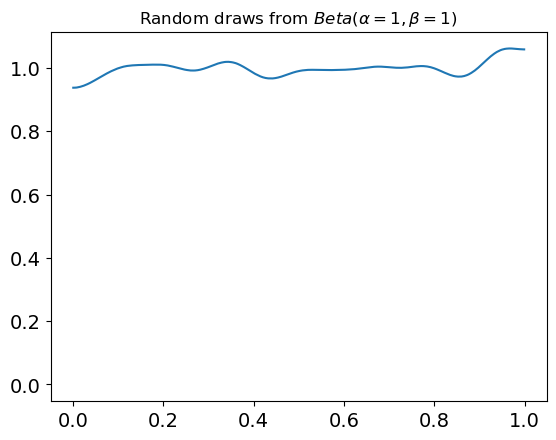

In [1]:
import pymc as pm
import arviz as az
import numpy as np

a, b = 1, 1  # we observed a - 1, failures and b - 1 successes (no prior data!)
rate_prior = pm.Beta.dist(alpha=a, beta=b)
ax = az.plot_dist(pm.draw(rate_prior, draws=10_000))
ax.set_title(f"Random draws from $Beta(\\alpha={a}, \\beta={b})$");

#### Mean and sample size parameterization

Alternately, we can think of having no prior information about a probability as having a mean of 0.5 (*i.e.* equal probability of event or no event) and a sample size of 0. 

The sample size is defined here as:

$$ n = \alpha + \beta - 2 $$

as a parameter $\kappa$, called the **concentration** defined as,

$$ \kappa = n + 2 = \alpha + \beta $$


Note that given our choices,

$$\alpha = p * \kappa = 0.5 * 2 = 1$$ 

and,

$$\beta = (1-p) * \kappa = 0.5 * 2 = 1$$

here, just as before!

#### Mean and standard deviation parameterization


Another way parameterize the $\operatorname{Beta}$ distribution, is to focus on the **mean** and **standard deviation** of the distribution. We can derive this parameterization by solving a few [coupled equations](https://en.wikipedia.org/wiki/Beta_distribution), but PyMC makes it even easier.

We can directly use the `mu` and `sigma` arguments with `pm.Beta`.

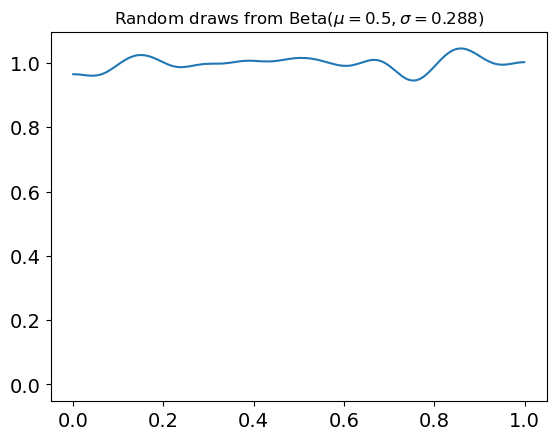

In [2]:
pbar, std = 0.5, 0.288
rate_prior = pm.Beta.dist(mu=pbar, sigma=std)
ax = az.plot_dist(pm.draw(rate_prior, draws=10_000))
ax.set_title(f"Random draws from $\\operatorname{{Beta}}(\\mu={pbar}, \\sigma={std})$");

#### Bonus Question:

> How did we get to a standard deviation of 0.288 here?

Simulation is a helpful visual approach for understanding the implications of different prior choices!

## Exercise: Advertising Conversion Rate

You work for a travel agency, GlobiTrav! 

A big customer asked you to place advertisements for a new holiday destination on Cape Cod in an off-shore underwater hotel. From June to October travellers will be guaranteed shark sightings from their hotel room if they stay longer than 3 days.

You are supposed to place some advertisements on relevant travel meta-pages and estimate the subsequent conversion rate. The customer has several variations of their advertisement, and wants to pick the most suitable via a small pilot experiment.

For each variant you will only get a few datapoints, so prior specification will matter to avoid overfitting and misinterpretation. Can you come up with and motivate a reasonable prior for the conversion rates in this case?

HINT: A quick web search reveals some general information about conversion rates in the travel industry.

> In the travel industry, conversion rates can vary from 0.2% to 4%. If your rate is above 2%, your website is in the top 20% of travel sites. Achieving a rate between 3% to 4% would position you among the best 10%.

In [3]:
# Write your anwser here

## Informative and Uninformative Priors

Formally, we justify a non-informative prior by the **Principle of Insufficient Reason**, which states that without specific reasons to favor any one outcome, it's rational to treat all outcomes as equally likely. This principle helps in assigning a fair and unbiased initial probability distribution in situations where there's a complete lack of knowledge about the likelihood of different events. However, sometimes it is inappropriate to employ an uninformative prior as we have done above. 

For some distributions there is no clear choice of such a prior, particularly when parameters are transformed. For example, a flat prior on the real line is not flat on the unit interval. 

Take a normal distribution with a large variance:

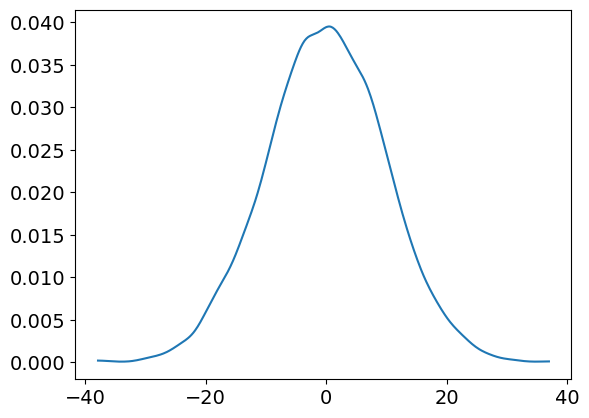

In [4]:
wide_normal = pm.Normal.dist(mu=0, sigma=10)
ax = az.plot_dist(pm.draw(wide_normal, draws=10_000))

... and transform it to the unit interval with the inverse-logit function:

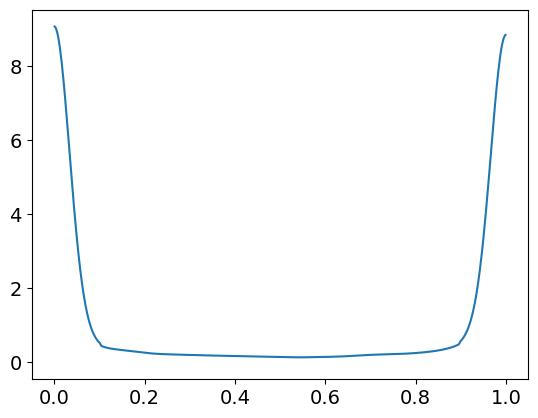

In [7]:
inverse_logit_normal = pm.math.invlogit(wide_normal)
ax = az.plot_dist(pm.draw(inverse_logit_normal, draws=10_000))

> #### Jeffreys Prior 
>
> The Jeffreys prior is a non-informative prior distribution for a parameter space, named after Sir Harold Jeffreys. Its density function is proportional to the square root of the determinant of the Fisher information matrix:
> 
> $$p(\vec{\theta}) \propto \sqrt{\det \mathcal{I}(\vec{\theta})}$$
>
> Where $\mathcal{I}(\vec{\theta})$ is the Fisher information matrix. The key feature of the Jeffreys prior is that it is invariant under transformation for the parameter vector $\vec{\theta}$, meaning the relative probability assigned to a volume of the probability space remains the same regardless of the parameterization used. This makes it particularly useful for scale parameters.
> 
> For example, for a Gaussian distribution with mean $\mu$ and fixed variance $\sigma^2$, the Jeffreys prior for $\mu$ is the improper uniform distribution, $p(\mu) \propto 1$, as it does not depend on $\mu$. For a binomial distribution with parameter $\theta$, the Jeffreys prior is $p(\theta) \propto \theta^{-1/2}(1-\theta)^{-1/2}$, which is a Beta(1/2, 1/2) distribution.


Stepping back from informative vs uninformative, there are two alternative interpretations of the prior distribution.

1. **Population prior**: a distribution that represents a notional population of values for the parameter, from which those in the current experiment/study have been drawn.
2. **Knowledge prior**: a distribution that represents our uncertainty about the true value of the parameter.

Whether or not there are pre-existing studies or datasets that can inform the choice of prior, the choice of prior distribution should be justified in terms of the model and the problem at hand. Even without extensive domain expertise, it is usually possible to place reasonable constraints on the prior distributions of any model.

For example:

- if we are modeling **disease prevalence**, we know that the true value will be much closer to zero than to one.
- in a **marketing study**, the mean cost of customer acquisition will not be tens of thousands of dollars.
- modeling **player value/ability in sports**, we know that the distribution of player abilities is likely to be right-skewed, with few players far above the mean.

When datasets are large, you can get away with gross prior misspecification. But when datasets are small, a well-specified prior can stabilize posterior estimates and predictions.

## Example: IQ scores

Consider the observatino of a 180 score in an IQ dataset, which is a normalized metric with a mean of 100 and a standard deviation of 15.

<center><img src="https://media.giphy.com/media/3o6Zt11R527fgtrIJO/giphy.gif" style="margin:auto" height="400" width="400"/></center>


**Do we have a genius on our hands?**

We know there is *measurement noise*, so we should already be skeptical.

Let's build a simple model!

In [8]:
with pm.Model() as iq_model:

    # Prior
    iq = pm.Normal("iq", 100, 100)  # totally ignorant prior assumption about IQ

    eps = 30  # we assume we know our measurement error

    # Likelihood
    obs = pm.Normal("obs", iq, eps, observed=180)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [iq]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


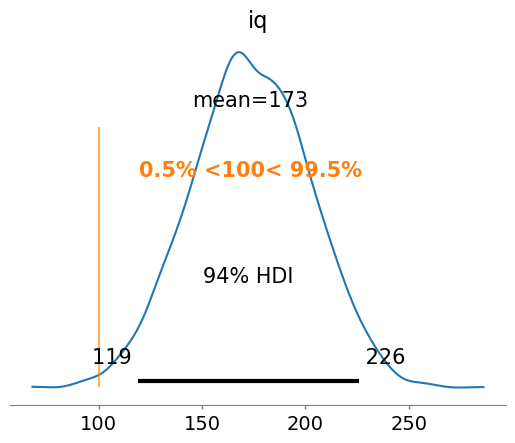

In [9]:
az.plot_posterior(trace, ref_val=100);

It's very clear our model gets swayed by any data you throw at it, even with a big measurement error and only one observation! As a modeler, you don't want that.

**Are you sure you're that smart?**

A quick internet search will inform us that IQ was constructed so as to have a mean of 100 and a standard deviation of 15, so we're even more skeptical now: an IQ of 180 is very unlikely, and we should incporporate that knowledge into our model.

How? With our prior! We'll use a  $\operatorname{Normal}(100,15)$
  as our prior for individual IQ, which will make the model more skeptical of extreme observations -- i.e, it will need more convincing data to make extreme inferences. That's another version of the colloquial "extraordinary claims require extraordinary evidence". Logical, right? In Bayesian parlance, we say that the actual estimate of IQ will get regularized towards 100.

### Putting more informative prior

Now what happens with our informative prior?

In [10]:
with pm.Model() as m:
    
    # Prior
    iq = pm.Normal("iq", 100, 15)  # weakly-informative prior

    eps = 30 
    obs = pm.Normal("obs", iq, eps, observed=180)

    # Sample
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [iq]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


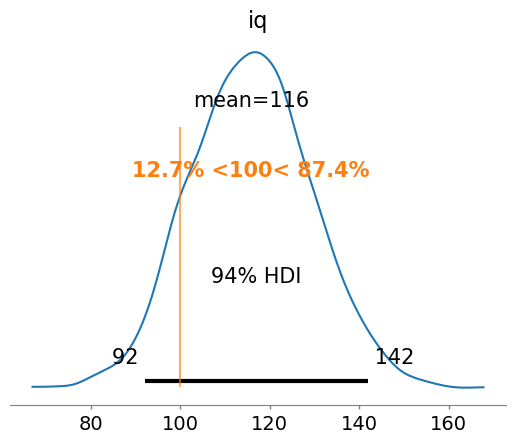

In [11]:
az.plot_posterior(trace, ref_val=100);

That looks more sensible, right? Our model needs more data to say that this person has an extremly high IQ. It's more probable (88%) that the person has a higher than average IQ, but not with the magnitude suggested by the data. There is even still a chance (12%) that the subject is below average. Remember: with big measurement error and only one data point, there is still a lot of uncertainty.

To sum up, **informative priors are helpful because they regularize your inferences**.

But remember this was just an example, setting the *measurement noise* to $30$ was an *assumption* that was not based on any particular information. A quick survey of the literature reveals that a standard deviation for measurement error of around $7$ may be appropriate.

## Choosing priors computationally

While you can use simulation to construct priors that meet our requirements, it does take some trial and error.

Recent versions of PyMC have a convenient utility function that can specify priors with particular coverage properties, using optimization.

In [12]:
MASS = 0.95  # probability mass we want in an interval
LOWER = 0.1  # lower bound of the interval
UPPER = 3  # upper bound of the interval

constrained_priors = pm.find_constrained_prior(
    pm.Gamma, lower=LOWER, upper=UPPER, mass=MASS, init_guess=dict(alpha=1, beta=1)
)

constrained_priors

{'alpha': 1.8470694064085307, 'beta': 1.6875496099757603}

This is particularly useful for distributions like the Gamma and Beta distributions, for which it can be difficult to develop an intuition regarding parameterization. So, if the only prior information you've got is "**I need a Gamma that has 95% probability mass between 0.1 and 3.0**", an approach like this is helpful.

Just to verify:

In [13]:
# Specify the prior distribution based on our optimized parameters
opt_distribution = pm.Gamma.dist(**constrained_priors)

# compute the mass inside our desired interval [LOWER, UPPER]
mass_in_interval = (
    pm.math.exp(pm.logcdf(opt_distribution, UPPER))
    - pm.math.exp(pm.logcdf(opt_distribution, LOWER))
).eval()

print(np.abs(mass_in_interval - MASS) <= 1e-5)

True


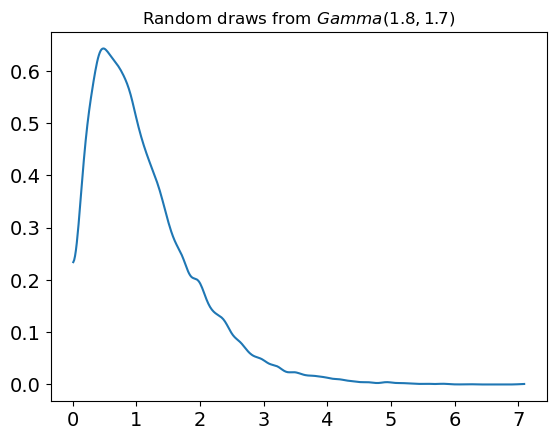

In [14]:
ax = az.plot_dist(pm.Gamma.dist(**constrained_priors, size=10_000).eval())
ax.set_title(
    f"Random draws from $Gamma({round(constrained_priors['alpha'], 1)}, {round(constrained_priors['beta'], 1)})$"
);

## Truncated Priors

In some cases, we may have prior information that suggests that the parameter of interest lies within a certain range with certainty. If you want to make use of arbitrary distributions for constructing priors, while guaranteeing that the parameter lies within a certain range, you can use a truncated distribution.

The `Truncated` object can be used to wrap any distribution in PyMC and have an upper and/or lower bound specified.

In [16]:
mu_tmp = (180 + 155) / 2
sigma_tmp = 10
LOWER_trunc = 155
UPPER_trunc = 180

In [17]:
with pm.Model():
    # specify a basic normal distribution
    normal_heights = pm.Normal.dist(mu=mu_tmp, sigma=sigma_tmp)
    # truncated it
    heights_prior = pm.Truncated(
        "trunc_normal_prior", normal_heights, lower=LOWER_trunc, upper=UPPER_trunc
    )
    # sample
    prior_samples = pm.draw(heights_prior, draws=10000)

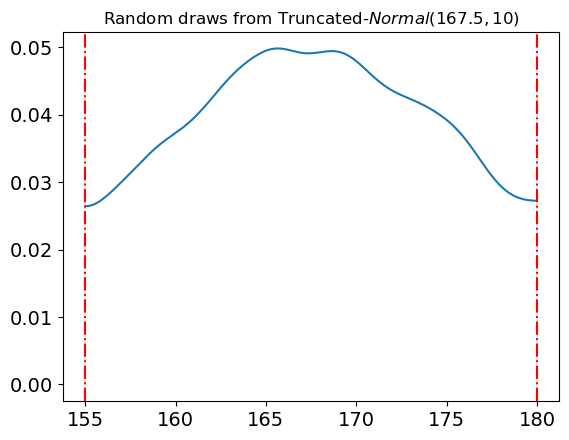

In [18]:
ax = az.plot_dist(prior_samples)
ax.set_title(
    f"Random draws from Truncated-$Normal({round(mu_tmp, 1)}, {round(sigma_tmp, 1)})$"
)
ax.axvline(x=LOWER_trunc, linestyle="-.", color="r")
ax.axvline(x=UPPER_trunc, linestyle="-.", color="r")

### Code Example

Let's try to combine the ideas in this section. Let's say we want a Normal prior which has $95\%$ mass between $160\text{cm}$ and $170\text{cm}$ and and at the same time is constrained to strictly lie between $150\text{cm}$ and $180\text{cm}$.

How would we do that?

In [25]:
# Write your answer here

**NOTE:**

If you very precisely care about your prior specification, here we leave a little bit on the line. 
Of course after calling `pm.Truncated()`, we may loose a bit of precision on our `mass=0.95` constraint.

In this particular example, the error will be very small (because the bulk of the distribution sits within the truncation constraints), but this of course doesn't always have to be the case.

However, as a *general rule of thumb*:

The business of specifying prior is however usually **strict** in constraints such as the truncations, on the other hand **less strict** in the mass constraints that give us the initial parameters of our $\operatorname{Normal}$ prior.

### Even more on priors?

Yes! Priors are important.

Software is being being built to help conveniently elicit priors from qualitative constraints you may want to impose.

Priors... Elicitation?... Prelicitation?.... well we suggest you to check out the [PreliZ](https://github.com/arviz-devs/preliz) package if you want to learn more...

## How much do priors actually matter?

In this section we are going to run a simple experiment to illustrate the impact of priors on our final inference.
We will take a sample from the $\operatorname{Normal}(\mu = 150, \sigma = 10)$ distribution and formulate two models to perform inference on the mean of the distribution.

1. `m_negbias` which has a $\operatorname{Normal}(100, 10)$ prior on $\mu$ (the real mean is $5$ standard deviations from the mean of this prior)
2. `m_poslowvar` which has a $\operatorname{Normal}(200, 4)$ prior on $\mu$ (the real mean is $12.5$ standard deviations from the mean of this prior in the opposite direction)

We then `sample` from both models for datasets of increasing size (`[1, 10, 100 , 250]`)

In [21]:
# Generate some normal data
normal_data = np.random.normal(loc=150, scale=10, size=1000)

In [22]:
posterior_dict_negbias = {}
posterior_dict_poslowvar = {}
sample_sizes = [1, 10, 100, 250]

# ------ Model with negative bias in prior ------
with pm.Model() as m_negbias:
    # Data
    data_obs = pm.MutableData("data_obs", normal_data[:10])
    # Prior
    iq = pm.Normal("iq", 100, 10)  # prior is biased towards lower mean than real data
    eps = 10  # we assume we know our measurement error
    # Likelihood
    obs = pm.Normal("obs", iq, eps, observed=data_obs)

for i in sample_sizes:
    print(f"Running for {i} data points")
    with m_negbias:
        m_negbias.set_data("data_obs", normal_data[:i])
        posterior_dict_negbias[i] = pm.sample(chains=1, progressbar=False)

# ------ Model with lower variance and positive bias in prior ------

with pm.Model() as m_poslowvar:
    data_obs = pm.MutableData("data_obs", normal_data[:10])
    # Prior
    iq = pm.Normal(
        "iq", 200, 4
    )  # prior is biased towards higher mean and we are a priori more certain about it
    eps = 10  # we assume we know our measurement error
    # Likelihood
    obs = pm.Normal("obs", iq, eps, observed=data_obs)

for i in sample_sizes:
    print(f"Running for {i} data points")
    with m_poslowvar:
        m_poslowvar.set_data("data_obs", normal_data[:i])
        posterior_dict_poslowvar[i] = pm.sample(chains=1, progressbar=False)

/home/cfonnesbeck/miniforge3/envs/bayes_course/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running for 1 data points


Sequential sampling (1 chains in 1 job)
NUTS: [iq]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running for 10 data points


Sequential sampling (1 chains in 1 job)
NUTS: [iq]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running for 100 data points


Sequential sampling (1 chains in 1 job)
NUTS: [iq]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running for 250 data points


Sequential sampling (1 chains in 1 job)
NUTS: [iq]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/cfonnesbeck/miniforge3/envs/bayes_course/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running for 1 data points


Sequential sampling (1 chains in 1 job)
NUTS: [iq]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running for 10 data points


Sequential sampling (1 chains in 1 job)
NUTS: [iq]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running for 100 data points


Sequential sampling (1 chains in 1 job)
NUTS: [iq]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running for 250 data points


Sequential sampling (1 chains in 1 job)
NUTS: [iq]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


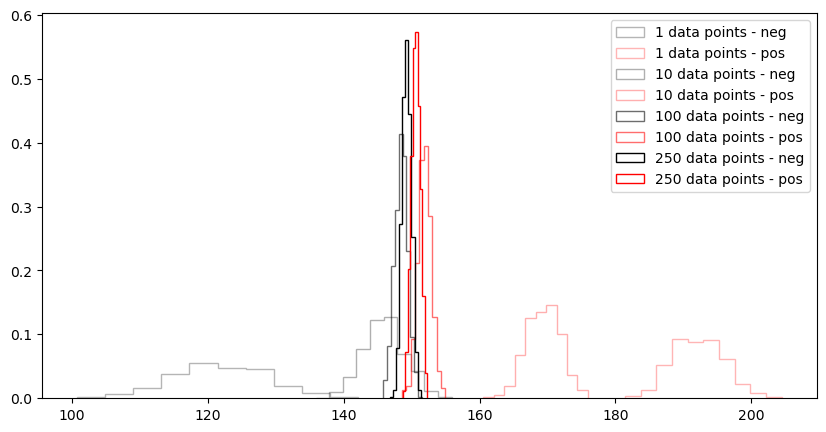

In [23]:
from matplotlib import pyplot as plt

# Plotting the posteriors
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in sample_sizes:
    ax.hist(
        posterior_dict_negbias[i]["posterior"].data_vars["iq"].values.reshape(-1),
        histtype="step",
        label=f"{i} data points - neg",
        alpha=(i + 100) / (np.max(sample_sizes) + 100),
        density=True,
        color="black",
    )
    ax.hist(
        posterior_dict_poslowvar[i]["posterior"].data_vars["iq"].values.reshape(-1),
        histtype="step",
        label=f"{i} data points - pos",
        alpha=(i + 100) / (np.max(sample_sizes) + 100),
        density=True,
        color="red",
    )
    ax.legend()

Note how the posteriors are slowly converging towards the same distribution. At $250$ data points our posteriors are already very similar, even though a priori we considered our synthetic dataset much less likely under the `m_poslowvar` model, as well as expecting data on oppositve sides of the true mean for our tested models!

Note also that, for illustration, this is a fairly extreme example. You will usually decide over variations of your priors that are **much less different** from each other, hence your posterior inferences would be **much more similar** even when less data is observed!

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jun 09 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

matplotlib: 3.8.4
pymc      : 5.15.1
arviz     : 0.18.0
numpy     : 1.26.4

Watermark: 2.4.3

